This package (censusify-philly) helps people to map census data (using the [census](https://pypi.org/project/census/) python package) to geographies in Philadelphia. We are using [shapely](https://pypi.org/project/shapely/) to manage the shapefile data.

**Before moving on, if you want to run this notebook, you will need to first acquire an API key for the US census data. You can do so [here](https://api.census.gov/data/key_signup.html).** Once you have this key, set it as an environment variable `CENSUS_API_KEY` or replace the variable below with the api key.

In [1]:
import os
census_api_key = os.environ['CENSUS_API_KEY']

This specific notebook will explain how to map **block-group level demographics data** to Philadelphia **Police Service Areas**, using shapefiles provided by the city of Philadelphia. At the bottom of this notebook is some cleaned up code that then generates CSV files of demographics for PSAs, districts, and divisions.

This work will require the following pieces of information:
- from the us government census: 
  - shapefiles for all US census block groups in the city of Philadelphia
  - demographic counts for all US census block groups in the city of Philadelphia
- from the city of Philadelphia
  - shapefiles for all Police Service Areas in the city of Philadelphia
  
Lucky for us, both the city of Philadelphia and the US government use ArcGIS to store their shapefile data, so it will be returned in relatively similar formats.

## Step 1: Download the Census block group shapefiles

The shapefiles for the US census data are on a server called tigerweb. The following [URL](https://tigerweb.geo.census.gov/arcgis/rest/services/Census2020/Tracts_Blocks/MapServer/1/query) points to the Arcgis server where anyone can directly make calls that specifically return results at the census block group level.

In [2]:
base_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/Census2020/Tracts_Blocks/MapServer/1/query"

There are several parameters to provide:

- **inSr/outSr**: The projection to return the data in. We want 4326, which is a reference to ESPG4326, which is the ESPG version of [WGS84](https://gisgeography.com/wgs84-world-geodetic-system/), which is the system that returns data in latitude and longitudes. 
- **where**: our query bounds. In our case we want to pass 'STATE=42 AND COUNTY=101' which represent PA and Philadelphia County respectively.
- **spatialRel**: How the results relate to the query. We want 'esriSpatialRelWithin' so we get all results that are within our query bounds.
- **f**: stands for format. We are returning it in JSON because thats the easiest to work with in python.
- **outFields**: The list of fields to return. We want all relevant location-related fields, as well as the lat/lng centroids.
- **returnGeometry**: Whether to return the geometry of the results. The geometry is a list of lat/lng pairs that when mapped represent the shape of a given geography.

In [3]:
import requests
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from census import Census
import pandas as pd

from censusify_philly.services.census.column_mappings import variable_race_mapping # or use appendix below
from censusify_philly.services.census.column_mappings import variable_hispanic_mapping # or use appendix below

In [4]:
state = "42"  # PA
county = "101"  # Philly

params = {
    'inSr': 4326,
    'outSr': 4326,
    'spatialRel': 'esriSpatialRelWithin',
    'outFields': 'STATE,COUNTY,TRACT,BLKGRP,GEOID,CENTLAT,CENTLON',
    'f': 'json',
    'where':f"STATE='{state}' AND COUNTY='{county}'",
    "geometryType": "esriGeometryPoint",
    "returnGeometry": True
}

response = requests.get(base_url, params).json()

In [5]:
# An example of one of the census block groups.
response['features'][0]

{'attributes': {'STATE': '42',
  'COUNTY': '101',
  'TRACT': '000101',
  'BLKGRP': '1',
  'GEOID': '421010001011',
  'CENTLAT': '+39.9517540',
  'CENTLON': '-075.1502277'},
 'geometry': {'rings': [[[-75.15195900002719, 39.95104300001514],
    [-75.15173499972121, 39.95207399966361],
    [-75.15153899990263, 39.952947999855134],
    [-75.14992600024982, 39.95275700025084],
    [-75.14847199970735, 39.95257800013032],
    [-75.14870400040925, 39.95152800030406],
    [-75.14876799998336, 39.95123600008627],
    [-75.14891699994628, 39.95055400006598],
    [-75.1503759996133, 39.9507339998877],
    [-75.15200000003507, 39.9509360000265],
    [-75.15195900002719, 39.95104300001514]]]}}

It'll be easier if instead of a list of geographies, we store them as a dictionary, keyed by the GEOID (which is a concatenation of the state,county,tract, and block group). We store them below as `philly_census_block_group_geographies`

In [6]:
philly_census_block_group_geographies = response['features']

all_census_geographies_dict = {
    feat['attributes']["GEOID"]: {
        "geometry": Polygon(feat['geometry']['rings'][0]),
        "centroid": Point(
            float(feat['attributes']['CENTLON']),
            float(feat['attributes']['CENTLAT']),
        )
    } 
    for feat in philly_census_block_group_geographies
}

## Step 2: Download the Census demographics data

This step includes some data cleaning, as the raw census data gives non-descriptive column names. However, if you have census demographics data already cleaned, you can simply create a dictionary that is keyed on the GEOIDs (similar to the dictionary above, make sure to fill in zeroes similarly to how it is done from Arcgis).

I had to look up the census columns to get the column names that are used for the Census API. 

In [7]:
race_cols = [f"P1_00{i}N" for i in range(3, 10)]
print("RACE:",race_cols)
hispanic_cols = ["P2_002N", "P2_003N"]
print("HISPANIC:",hispanic_cols)
race_hispanic_cols = [f"P2_0{i:02}N" for i in range(4, 12)]
print("RACE+HISPANIC:",race_hispanic_cols)

RACE: ['P1_003N', 'P1_004N', 'P1_005N', 'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N']
HISPANIC: ['P2_002N', 'P2_003N']
RACE+HISPANIC: ['P2_004N', 'P2_005N', 'P2_006N', 'P2_007N', 'P2_008N', 'P2_009N', 'P2_010N', 'P2_011N']


In [8]:
census_demographics_fields = ["NAME"] + race_cols + hispanic_cols + race_hispanic_cols
census_demographics_fields

['NAME',
 'P1_003N',
 'P1_004N',
 'P1_005N',
 'P1_006N',
 'P1_007N',
 'P1_008N',
 'P1_009N',
 'P2_002N',
 'P2_003N',
 'P2_004N',
 'P2_005N',
 'P2_006N',
 'P2_007N',
 'P2_008N',
 'P2_009N',
 'P2_010N',
 'P2_011N']

In [9]:
census_obj = Census(census_api_key)
census_demo_results = census_obj.pl.state_county_blockgroup(
    fields=census_demographics_fields,
    state_fips=state,
    county_fips=county,
    tract="*",
    blockgroup="*"
)

I used this [link](https://api.census.gov/data/2020/dec/pl/variables.json) to create a more sensible mapping from these numerical columns (for example P2_006N) to descriptive column names (for example p1_multiracial). Check the appendix at the end for the full mappings printed out, I also stored them in this library so I can easily access the mapping, its a dictionary called `variable_race_mapping`. I also did some hacky manipulation of the column names to make them more readable.

We also then map the demographics to the demographics that match police data, including the combination of race and latino/non-latino status.

In [10]:
def rename_key(key):
    if key in variable_race_mapping.keys():
        output = (
            "p1_"
            + variable_race_mapping[key]
            .replace("!!Total:!!", "")
            .replace("Population of one race:!!", "")
            .replace("Population of two or more races", "Multiracial")
            .strip()
        )
    elif key in variable_hispanic_mapping.keys():
        output = (
            "p2_"
            + variable_hispanic_mapping[key]
            .replace("!!Total:!!", "")
            .replace("Population of one race:!!", "")
            .replace("Population of two or more races", "Multiracial")
            .strip()
        )
    else:
        output = key
    return output.replace(" ", "_").lower()


def census_to_odp_demographics_mapping(census_data):
    state_fips = census_data['state']
    county_fips = census_data['county']
    census_tract = census_data['tract']
    census_block_group = census_data['block_group']
    geoid = f"{state_fips}{county_fips}{census_tract}{census_block_group}"
    # Philly Police do not have a separate category for Pacific Islanders/Hawaiians
    return {
        "geoid": geoid,
        "American Indian": census_data["p1_american_indian_and_alaska_native_alone"],
        "Asian": census_data["p1_asian_alone"]
        + census_data["p1_native_hawaiian_and_other_pacific_islander_alone"],
        "Unknown": census_data["p1_some_other_race_alone"]
        + census_data["p1_multiracial:"],
        "White - Non-Latino": census_data["p2_not_hispanic_or_latino:!!white_alone"],
        "White - Latino": census_data["p1_white_alone"]
        - census_data["p2_not_hispanic_or_latino:!!white_alone"],
        "Black - Non-Latino": census_data[
            "p2_not_hispanic_or_latino:!!black_or_african_american_alone"
        ],
        "Black - Latino": census_data["p1_black_or_african_american_alone"]
        - census_data["p2_not_hispanic_or_latino:!!black_or_african_american_alone"],
    }

renamed_results = [
    census_to_odp_demographics_mapping(
        {rename_key(k): v for k, v in result.items()}) for result in census_demo_results
]

Next we take this list and we make a dictionary keyed on GEOID (similar to the census geography data)

In [11]:
all_census_data_dict = {key['geoid']:key for key in renamed_results}

## Step 3: Get PSA geography from the city

This query looks very similar to the Census geography query because it also uses Arcgis. Key differences are that we want all of the `outFields` so we pass a `*`. We also want all of the PSAs, so we pass where `1=1`.

In [12]:
# PSA Geographies
psa_url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_PSA/FeatureServer/0/query"


state = "42"  # PA
county = "101"  # Philly

params = {
    'inSr': 4326,
    'outSr': 4326,
    'spatialRel': 'esriSpatialRelWithin',
    'outFields': '*',
    'f': 'json',
    'where':"1=1",
    "geometryType": "esriGeometryPoint",
    "returnGeometry": True
}

all_psa_data = requests.get(psa_url, params).json()
all_psa_dict = {psa['attributes']['PSA_NUM']:psa['geometry']['rings'][0] for psa in all_psa_data['features']}

## Step 4: Mapping census geographic data to PSAs

This example will go in detail on one PSA. The following will use District 14, PSA 4 as an example. This will be referenced as full PSA 144. 

We need to map the geography, and create weights for each census geography assigned to each PSA. These weightings are then used to assign demographics data.

There are two methods that can be used to do this mapping. 

1) By block group centroid
2) By % area overlap

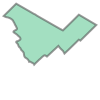

In [13]:
psa_name = '144'
psa_x = Polygon(all_psa_dict[psa_name])
psa_x

### Step 4, Option 1: Map census geography data to PSAs (By Block Group centroid)

This is a method commonly used in research papers that assigns the full demographics from all census block groups that have centroids inside of a PSA.

In [14]:
census_block_groups_by_centroid = {
    census_name: 1
    for census_name, census_x in all_census_geographies_dict.items()
    if census_x['centroid'].within(psa_x) 
}
census_block_groups_by_centroid

{'421010231001': 1,
 '421010255002': 1,
 '421010257002': 1,
 '421010257003': 1,
 '421010257004': 1,
 '421010259001': 1,
 '421010259002': 1,
 '421010259003': 1,
 '421010260003': 1,
 '421010255001': 1,
 '421010255003': 1,
 '421010256002': 1,
 '421010256003': 1,
 '421010256001': 1,
 '421010258001': 1,
 '421010257001': 1,
 '421010259004': 1,
 '421010259005': 1,
 '421010260002': 1,
 '421010260001': 1,
 '421010261001': 1,
 '421010261002': 1,
 '421010261003': 1,
 '421010385001': 1,
 '421010386001': 1,
 '421010387002': 1,
 '421010387001': 1,
 '421010388001': 1}

The plot below is a grey area (representing the PSA) overlayed with a red area (the census block groups that are associated with that PSA). The lines represent the boundaries of the census block groups.

It can be seen that the plot below has some gray missing area (where part of the PSA isn't being overlapped by any census block group), and some light pink area of one of the census block groups are partially outside the PSA. These mismatches may lead to errors in the demographic mapping step.

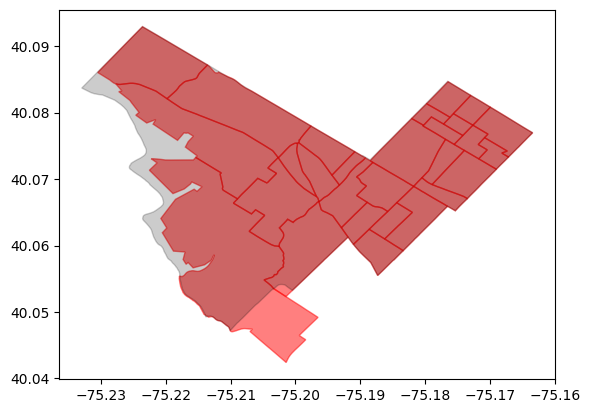

In [15]:
for census_block_group, weight in census_block_groups_by_centroid.items():
    plt.fill(*all_census_geographies_dict[census_block_group]['geometry'].exterior.xy, label=census_block_group, color='red', alpha=0.5)
plt.fill(*psa_x.exterior.xy, label=psa_name, color='black', alpha=0.2)

### Step 4, Option 2: Map census geography data to PSAs (By % area covered)

In this method, we find all of the census block groups that overlap in some way to the given PSA and calculate what % of that Census Block Group overlaps with the PSA. There are some rounding errors with census block groups that touch but don't overlap with PSAs, so we remove Census Block groups with a calculated area that is very small (because that indicates they simply are touching).

The following code also calculates the percent area of each given Census Block Group that overlaps with the PSA. This will later be used to weight the demographics data from each Census Block Group to a given PSA. 

In [16]:
census_block_groups_pct_area = {
    census_name: census_x['geometry'].intersection(psa_x).area / census_x['geometry'].area
    for census_name, census_x in all_census_geographies_dict.items()
    if census_x['geometry'].intersects(psa_x) and census_x['geometry'].intersection(psa_x).area >= 0.000001
}
census_block_groups_pct_area

{'421010231001': 1.0000000000000002,
 '421010255002': 0.9978735416513622,
 '421010257002': 0.9999999999999991,
 '421010257003': 1.0000000000000002,
 '421010257004': 0.9982833763899619,
 '421010259001': 0.9986754356987178,
 '421010259002': 0.9999999999999999,
 '421010259003': 1.0,
 '421010260003': 1.0000000000000004,
 '421010255001': 1.0,
 '421010255003': 0.9971188054839467,
 '421010256002': 0.9997512606899039,
 '421010256003': 1.0000000000000004,
 '421010256001': 1.0,
 '421010258001': 1.0000000000000007,
 '421010257001': 0.9999999999999999,
 '421010259004': 1.0000000000000002,
 '421010259005': 0.9999999999999998,
 '421010260002': 0.9980449310922245,
 '421010260001': 0.997213265315918,
 '421010261001': 0.9984586862697568,
 '421010261002': 0.9978532365957057,
 '421010261003': 0.9999999999999998,
 '421010385001': 1.0,
 '421019801001': 0.16659246395088456,
 '421010386001': 0.8004735996626638,
 '421010387002': 1.0000000000000004,
 '421010387001': 0.9984755394667154,
 '421010388001': 0.96524

 The plot below is a grey area (representing the PSA) overlayed with a red area (the census block groups that are associated with that PSA). The lines represent the boundaries of the census block groups.
 
 While it looks like an additional census block group (421019801001, the light pink one at the bottom of the plot) was added that only slightly overlaps with the given PSA, this is accounted for because its weight is 0.16 (as can be seen in the last line of the dictionary above), meaning that this method assumes that only 16% of the population of that census block group live in the PSA.

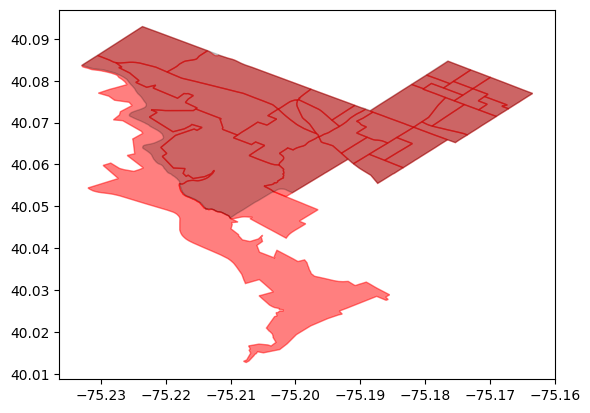

In [17]:
for census_block_group, weight in census_block_groups_pct_area.items():
    plt.fill(*all_census_geographies_dict[census_block_group]['geometry'].exterior.xy, label=census_block_group, color='red', alpha=0.5)
plt.fill(*psa_x.exterior.xy, label=psa_name, color='black', alpha=0.2)

## Step 5: Assign census demographic data to PSAs

Given a dictionary (where the keys are the block groups that we think are in that PSA, and the values are the weights), we can then assign demographics data to PSAs.

We will calculate the demographics for the prior PSA using both methods.


In [18]:
census_pct = census_block_groups_pct_area

The following shows the demographics for each Census Block Group that we previously said is associated with a given PSA.

In [19]:
census_series = pd.Series(census_pct)
census_series = census_series[census_series > 0]

demographics_of_overlapping_block_groups_df = pd.DataFrame(all_census_data_dict).T.drop('geoid',axis=1).loc[census_series.index]
demographics_of_overlapping_block_groups_df

,American Indian,Asian,Unknown,White - Non-Latino,White - Latino,Black - Non-Latino,Black - Latino
421010231001,5.0,44.0,92.0,1086.0,10.0,48.0,0.0
421010255002,3.0,15.0,130.0,380.0,6.0,653.0,15.0
421010257002,3.0,14.0,73.0,569.0,4.0,48.0,4.0
421010257003,0.0,66.0,51.0,184.0,10.0,431.0,2.0
421010257004,6.0,70.0,94.0,399.0,15.0,566.0,5.0
421010259001,6.0,6.0,39.0,18.0,0.0,661.0,7.0
421010259002,3.0,1.0,41.0,6.0,1.0,695.0,4.0
421010259003,2.0,0.0,34.0,13.0,3.0,739.0,4.0
421010260003,2.0,15.0,45.0,11.0,3.0,1114.0,9.0
421010255001,3.0,20.0,51.0,299.0,2.0,306.0,9.0


Next (and this is only relevant for the method using the % area method), we multiply the number of people in a given census block group by the % area of the Census Block Group that overlaps with the PSA to get the estimated number of people in each Census Block Group that are also in that PSA. 

As you can see below, the numbers are similar to the above for most Census Block Groups, with the exception of the last row, which we previously saw only had 16% overlap. Above shows 37 White Non-Latino people live in Census Block Group 421019801001, but we belive that only 6 of those people live in the PSA.

In [20]:
demographics_of_overlapping_block_groups_df.mul(census_series,axis=0)

,American Indian,Asian,Unknown,White - Non-Latino,White - Latino,Black - Non-Latino,Black - Latino
421010231001,5.0,44.0,92.0,1086.0,10.0,48.0,0.0
421010255002,2.993621,14.968103,129.72356,379.191946,5.987241,651.611423,14.968103
421010257002,3.0,14.0,73.0,569.0,4.0,48.0,4.0
421010257003,0.0,66.0,51.0,184.0,10.0,431.0,2.0
421010257004,5.9897,69.879836,93.838637,398.315067,14.974251,565.028391,4.991417
421010259001,5.992053,5.992053,38.948342,17.976158,0.0,660.124463,6.990728
421010259002,3.0,1.0,41.0,6.0,1.0,695.0,4.0
421010259003,2.0,0.0,34.0,13.0,3.0,739.0,4.0
421010260003,2.0,15.0,45.0,11.0,3.0,1114.0,9.0
421010255001,3.0,20.0,51.0,299.0,2.0,306.0,9.0


After summing all of the people across all the associated census block groups in the given PSA, we round to make sure we get even numbers of people. We then end up with the demographics of the PSA.

In [21]:
demographics_of_overlapping_block_groups_df.mul(census_series,axis=0).sum().astype(float).round().to_dict()

{'American Indian': 71.0,
 'Asian': 562.0,
 'Unknown': 1976.0,
 'White - Non-Latino': 9970.0,
 'White - Latino': 166.0,
 'Black - Non-Latino': 15212.0,
 'Black - Latino': 182.0}

Lets see how this compares to the centroid method. It seems like the % area method includes 2 more 'Black Non-Latino' people and 4 more 'White - Non-Latino' people.

In [22]:
census_pct_by_centroid = census_block_groups_by_centroid
census_series_by_centroid = pd.Series(census_pct_by_centroid)
census_series_by_centroid = census_series_by_centroid[census_series_by_centroid > 0]

pd.DataFrame(all_census_data_dict).T.drop('geoid',axis=1).loc[
    census_series_by_centroid.index
].mul(census_series,axis=0).sum().astype(float).round().to_dict()

{'American Indian': 71.0,
 'Asian': 562.0,
 'Unknown': 1975.0,
 'White - Non-Latino': 9964.0,
 'White - Latino': 166.0,
 'Black - Non-Latino': 15210.0,
 'Black - Latino': 182.0}

## The full code for all PSAs, Districts, Divisions, and the City using some cleaned up functions.

In [30]:
from census import Census
import os
import json
from shapely.geometry import Polygon
import pandas as pd

from censusify_philly.services.census.models import (
    CensusDataQuery,
)
from censusify_philly.services.arcgis import ArcgisQuery

# map census demographics to ODP Demographics Columns
def census_data_to_odp_demographics_mapping(census_data):
    # Philly Police do not have a separate category for Pacific Islanders/Hawaiians
   

    race_dict = {
        "american_indian": census_data["p2_not_hispanic_or_latino:!!american_indian_and_alaska_native_alone"],
        "asian": census_data["p2_not_hispanic_or_latino:!!asian_alone"]
        + census_data["p2_not_hispanic_or_latino:!!native_hawaiian_and_other_pacific_islander_alone"],
        "unknown": census_data["p2_not_hispanic_or_latino:!!some_other_race_alone"]
        + census_data["p2_not_hispanic_or_latino:!!multiracial:"],
        "white": census_data["p2_not_hispanic_or_latino:!!white_alone"],
        "black": census_data[
            "p2_not_hispanic_or_latino:!!black_or_african_american_alone"
        ],
        "hispanic_or_latino": census_data["p2_hispanic_or_latino"]
    }

from enum import Enum

class CensusBlockRelationship(str, Enum):
    overlap = "overlap"
    centroid = "centroid"
    
class CensusGeoMatcher:
    def __init__(self, /, *, census_data_dict, census_geographies_dict):
        self.census_data_dict = census_data_dict
        self.census_geographies_dict = census_geographies_dict

    def _get_census_blocks_in_geography_by_pct_area(self, geo_polygon):
        census_block_groups = {
            census_name: census_x['geometry']
            for census_name, census_x in self.census_geographies_dict.items()
            if census_x['geometry'].intersects(geo_polygon)
            and census_x['geometry'].intersection(geo_polygon).area > 0.000001
        }
        return {
            census_name: census_x.intersection(geo_polygon).area / census_x.area
            for census_name, census_x in census_block_groups.items()
        }
    
    def _get_census_blocks_in_geography_by_centroid(self, geo_polygon):
        return {
            census_name: 1
            for census_name, census_x in self.census_geographies_dict.items()
            if census_x['centroid'].within(psa_x) 
        }

    def get_demographics_from_census_blocks(self, geo_polygon, 
                                                relationship: CensusBlockRelationship=CensusBlockRelationship.centroid):
        """
        Now we want to get a dictionary where for a given police geography,
        we know the demographics.
        We do this by adjusting each census block group by how much of it is
        in a police geography and then summing the result
        for every census block group in the police geography.
        We then round to make sure we get whole people numbers
        """
        if relationship == CensusBlockRelationship.overlap:
            census_pct = self._get_census_blocks_in_geography_by_pct_area(geo_polygon)
        elif relationship == CensusBlockRelationship.centroid:
            census_pct = self._get_census_blocks_in_geography_by_centroid(geo_polygon)

        census_series = pd.Series(census_pct)

        # For all census block groups that are in the PSA, 
        # multiply the n_people by the % area of the PSA that
        # census block group takes up. If this is using the centroid method,
        # then it just assigns 100% of the people from each census block group with a centroid
        # that is within the geography.
        return (
            pd.DataFrame(self.census_data_dict)
            .T.loc[census_series.index]
            .mul(census_series, axis=0)
            .sum()
            .round()
            .to_dict()
        )
  

In [27]:



# Get all shapefiles for PSAs and Census Block Groups
# This is used to build the pct mapping
state = "42"  # PA
county = "101"  # Philly

## DEMOGRAPHICS BY BLOCK GROUP?
county_census_demographics = (
    await census_data_query.get_all_demographic_data_for_county(state, county)
)
all_census_data_dict = {
    result.census_geoid: census_to_odp_demographics_mapping(result.census_data)
    for result in county_census_demographics
}

# CENSUS GEOGRAPHIES BY BLOCK GROUP?
philly_census_block_group_geographies = await arcgis_query.get_all_by_attribute(
    where_str=f"STATE='{state}' AND COUNTY='{county}'"
)
all_census_geographies_dict = {
    feat.attributes["GEOID"]: Polygon(feat.geometry_ring)
    for feat in philly_census_block_group_geographies
}
census_geo_matcher = CensusGeoMatcher(
    all_census_data_dict, all_census_geographies_dict
)

# Division Geographies
print("Division")
psa_url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_PSA/FeatureServer/0/query"
division_url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_Division/FeatureServer/0/query?outFields=*&where=1%3D1"
all_division_data = await ArcgisQuery(division_url).get_all_by_attribute(
    where_str="1=1"
)
division_demographics = [
    {
        "division": feat.attributes["DIV_NAME"],
        **census_geo_matcher.get_demographics_based_on_overlap_with_census_blocks(
            Polygon(feat.geometry_ring)
        ),
    }
    for feat in all_division_data
]

# District Geographies
print("District")
district_url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_District/FeatureServer/0/query?outFields=*&where=1%3D1"
all_district_data = await ArcgisQuery(district_url).get_all_by_attribute(
    where_str="1=1"
)
district_demographics = [
    {
        "division": feat.attributes["DIV_CODE"],
        "district": f'{feat.attributes["DIST_NUM"]:02d}',
        **census_geo_matcher.get_demographics_based_on_overlap_with_census_blocks(
            Polygon(feat.geometry_ring)
        ),
    }
    for feat in all_district_data
]
district_to_division_mapping = {
    dist["district"]: dist["division"] for dist in district_demographics
}

# PSA Geographies
print("PSA")
psa_url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_PSA/FeatureServer/0/query"
all_psa_data = await ArcgisQuery(psa_url).get_all_by_attribute(where_str="1=1")
psa_demographics = [
    {
        "division": district_to_division_mapping[feat.attributes["PSA_NUM"][:2]],
        "district": feat.attributes["PSA_NUM"][:2],
        "psa": feat.attributes["PSA_NUM"][2:],
        "full_psa_num": feat.attributes["PSA_NUM"],
        **census_geo_matcher.get_demographics_based_on_overlap_with_census_blocks(
            Polygon(feat.geometry_ring)
        ),
    }
    for feat in all_psa_data
]

# Custom Geography
print("Citywide")
citywide = pd.DataFrame(all_census_data_dict).sum(axis=1).to_dict()
custom_geo_demographics = {
    "citywide": census_geo_matcher._get_demographics_results_and_pct_from_dict(
        citywide
    )
}
psa_df = pd.DataFrame(psa_demographics)
psa_df.drop(['demographics_count','demographics_percent'],axis=1).join(
    psa_df['demographics_count'].apply(pd.Series)
).to_csv('psa_demographics.csv', index=False)

district_df = pd.DataFrame(district_demographics)
district_df.drop(['demographics_count','demographics_percent'],axis=1).join(
    district_df['demographics_count'].apply(pd.Series)
).to_csv('district_demographics.csv', index=False)

division_df = pd.DataFrame(division_demographics)
division_df.drop(['demographics_count','demographics_percent'],axis=1).join(
    division_df['demographics_count'].apply(pd.Series)
).to_csv('division_demographics.csv', index=False)
print("Complete")



Division
District
PSA
Citywide
Complete


## Appendix

variable_race_mapping

In [25]:
print(json.dumps(variable_race_mapping, indent=4))

{
    "P1_009N": " !!Total:!!Population of two or more races:",
    "P1_008N": " !!Total:!!Population of one race:!!Some Other Race alone",
    "P1_007N": " !!Total:!!Population of one race:!!Native Hawaiian and Other Pacific Islander alone",
    "P1_019N": " !!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Some Other Race",
    "P1_018N": " !!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Native Hawaiian and Other Pacific Islander",
    "P1_006N": " !!Total:!!Population of one race:!!Asian alone",
    "P1_029N": " !!Total:!!Population of two or more races:!!Population of three races:!!White; Black or African American; Native Hawaiian and Other Pacific Islander",
    "P1_005N": " !!Total:!!Population of one race:!!American Indian and Alaska Native alone",
    "P1_017N": " !!Total:!!Population of two or more races:!!Population of two races:!!Black or African American; Asian",
    "P1_016N": "

variable_hispanic_mapping

In [26]:
print(json.dumps(variable_hispanic_mapping, indent=4))

{
    "P2_070N": " !!Total:!!Not Hispanic or Latino:!!Population of two or more races:!!Population of five races:!!White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race",
    "P2_071N": " !!Total:!!Not Hispanic or Latino:!!Population of two or more races:!!Population of five races:!!Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race",
    "P2_073N": " !!Total:!!Not Hispanic or Latino:!!Population of two or more races:!!Population of six races:!!White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race",
    "P2_072N": " !!Total:!!Not Hispanic or Latino:!!Population of two or more races:!!Population of six races:",
    "P2_060N": " !!Total:!!Not Hispanic or Latino:!!Population of two or more races:!!Population of four races:!!Black or African American; American Indian and Alaska 